# PCAで手書き文字(MNIST)を画像生成

In [1]:
#ライブラリのインポート
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# MNIST データセットのインポート
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# 3だけを5000イベント使用
images = train_images[train_labels == 3][:5000]

### オリジナル画像の表示

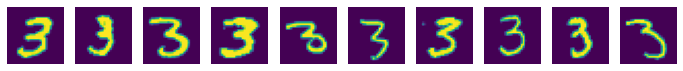

In [3]:
fig = plt.figure(figsize=(12, 20))

for j in range(10):
    ax = fig.add_subplot(1, 10, 1 + j)
    ax.imshow(images[j])
    ax.axis('off')


### PCAの適用

In [4]:
from sklearn.decomposition import PCA
pca = PCA()
_ = pca.fit(images.reshape([-1, 28 * 28]))


### 主成分ベクトルの表示

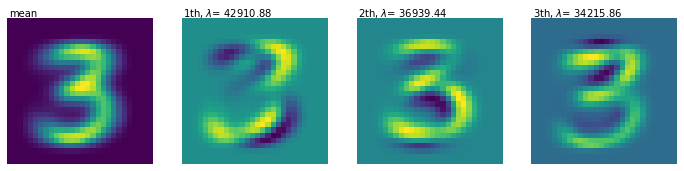

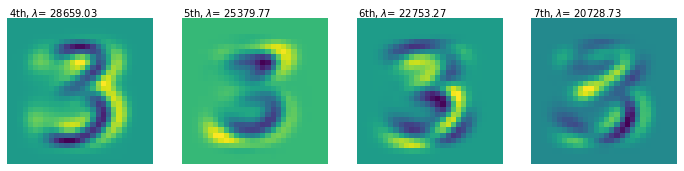

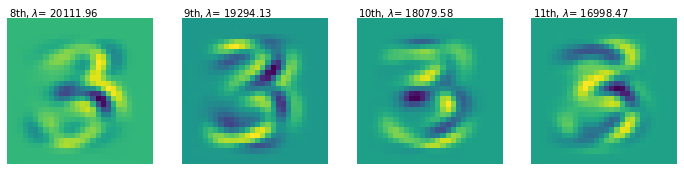

In [5]:
for j in range(12):
    if j % 4 == 0:
        fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 4, 1 + j % 4)
    if j == 0:
        ax.imshow(pca.mean_.reshape([28, 28]))
        ax.text(0.01, 1.01, 'mean', transform=ax.transAxes)
    else:
        ax.imshow(pca.components_[j-1].reshape([28, 28]))
        ax.text(0.01, 1.01, f'{j}th, ' + r'$\lambda$=' + f'{pca.singular_values_[j-1]: 2.2f}', transform=ax.transAxes)
    ax.axis('off')

### 画像生成
PCAで変換をした先の潜在空間上($z$)で乱数を生成、PCAの逆変換により元の座標に戻す

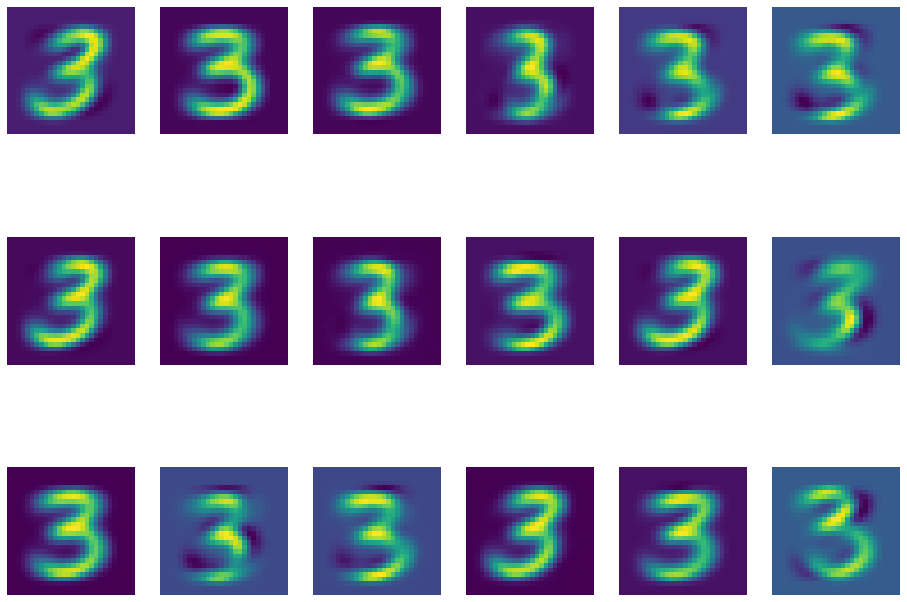

In [6]:
n_gen = 18
n_comp = 3  # 3個目までの主成分を使用
z = np.zeros([n_gen, 28 * 28])
for i in range(n_comp):
    # 潜在空間上で乱数をふる
    z[:, i] = np.sqrt(pca.explained_variance_[i]) * np.random.normal(size=n_gen)
# 実空間に戻す
image_gen = pca.inverse_transform(z).reshape([-1, 28, 28])

fig = plt.figure(figsize=(16, 12))
for j in range(n_gen):
    ax = fig.add_subplot(3, 6, 1 + j)

    ax.imshow(image_gen[j])
    ax.axis('off')


## 2段階の PCA
ATLASのCalorimeter fast simulationではPCAを2段階で適用することによって、より柔軟な変換を実現している。
1つ目のPCAで主成分ベクトルを得た後、その軸に沿ってイベントをビン分けし、ビンごとに再度新しいPCAで変換を行う。

In [7]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=1)
_ = pca_1.fit(images.reshape([-1, 28 * 28]))

comp_1st = pca_1.transform(images.reshape([-1, 28 * 28]))[:, 0:1]

from sklearn.preprocessing import QuantileTransformer
comp_1st = QuantileTransformer().fit_transform(comp_1st)

pca_2 = []
n_bins = 10
n_components = 20
for i in range(n_bins):
    cut = np.ones(len(images), dtype='bool')
    cut = np.logical_and(cut, comp_1st.flatten() >= 1 / n_bins * i)
    cut = np.logical_and(cut, comp_1st.flatten() < 1 / n_bins * (i + 1))
    p = PCA(n_components=n_components)
    _ = p.fit(images[cut].reshape([-1, 28 * 28]))
    pca_2 += [p]


### 2段階目のPCAの主成分ベクトル

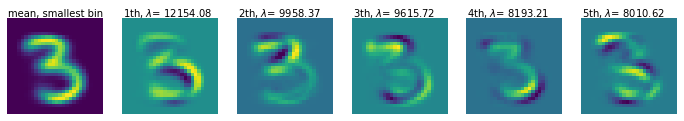

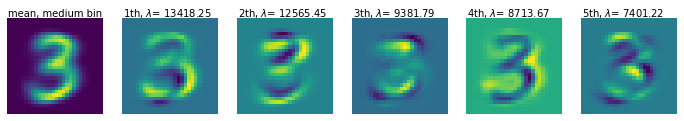

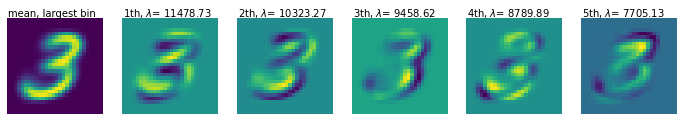

In [11]:
index_pca_2 = 0
fig = plt.figure(figsize=(12, 12))
for j in range(6):
    ax = fig.add_subplot(1, 6, 1 + j)
    if j == 0:
        ax.imshow(pca_2[index_pca_2].mean_.reshape([28, 28]))
        ax.text(0.01, 1.01, 'mean, smallest bin', transform=ax.transAxes)
    else:
        ax.imshow(pca_2[index_pca_2].components_[j-1].reshape([28, 28]))
        ax.text(0.01, 1.01, f'{j}th, ' + r'$\lambda$=' + f'{pca_2[index_pca_2].singular_values_[j-1]: 2.2f}', transform=ax.transAxes)
    ax.axis('off')

index_pca_2 = n_bins // 2
fig = plt.figure(figsize=(12, 12))
for j in range(6):
    ax = fig.add_subplot(1, 6, 1 + j)
    if j == 0:
        ax.imshow(pca_2[index_pca_2].mean_.reshape([28, 28]))
        ax.text(0.01, 1.01, 'mean, medium bin', transform=ax.transAxes)
    else:
        ax.imshow(pca_2[index_pca_2].components_[j-1].reshape([28, 28]))
        ax.text(0.01, 1.01, f'{j}th, ' + r'$\lambda$=' + f'{pca_2[index_pca_2].singular_values_[j-1]: 2.2f}', transform=ax.transAxes)
    ax.axis('off')

index_pca_2 = -1
fig = plt.figure(figsize=(12, 12))
for j in range(6):
    ax = fig.add_subplot(1, 6, 1 + j)
    if j == 0:
        ax.imshow(pca_2[index_pca_2].mean_.reshape([28, 28]))
        ax.text(0.01, 1.01, 'mean, largest bin', transform=ax.transAxes)
    else:
        ax.imshow(pca_2[index_pca_2].components_[j-1].reshape([28, 28]))
        ax.text(0.01, 1.01, f'{j}th, ' + r'$\lambda$=' + f'{pca_2[index_pca_2].singular_values_[j-1]: 2.2f}', transform=ax.transAxes)
    ax.axis('off')

### 画像生成

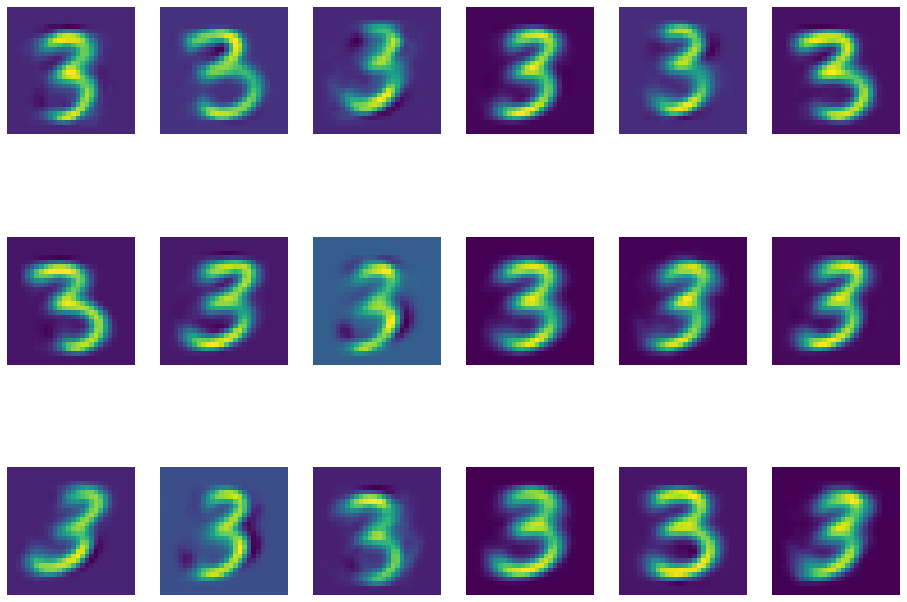

In [9]:
n_gen = 18
n_comp = 3  # 3個目までの主成分を使用

explained_variance = np.empty((n_bins, n_comp))
image_gen = np.empty((n_gen, 28, 28))
for i_gen in range(n_gen):
    i_pca_2 = np.random.choice(n_bins)
    p = pca_2[i_pca_2]

    z = np.zeros([n_components])
    for i in range(n_comp):
        # 潜在空間上で乱数をふる
        z[i] = np.sqrt(p.explained_variance_[i]) * np.random.normal()
    # 実空間に戻す
    image_gen[i_gen] = p.inverse_transform(z).reshape([28, 28])

fig = plt.figure(figsize=(16, 12))
for j in range(n_gen):
    ax = fig.add_subplot(3, 6, 1 + j)

    ax.imshow(image_gen[j])
    ax.axis('off')
